In [1]:
%matplotlib inline
%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [2]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import simtk.openmm as mm
from msmbuilder.decomposition import tICA, PCA

In [3]:
dataFull = np.loadtxt('ala4_explicit/COLVAR_md_explicit_10ns')

In [4]:
data = dataFull[:,1:7]
sumabs=dataFull[:,-1]


In [5]:
print(data)
print(sumabs)

[[-2.401463  2.721934 -1.359381  2.476104 -1.271216  2.361919]
 [-2.341986  2.873031 -1.109471  2.587082 -1.49281  -3.125739]
 [-2.458682  2.601563 -1.365601  2.60777  -1.5563    3.084817]
 ...
 [-1.381258  2.279866 -2.30461   3.077384 -1.124621  2.815719]
 [-1.695112  1.912944 -1.793466  2.932431 -1.201032  2.709006]
 [-1.37564   1.898676 -1.830701  2.715888 -0.99448   2.054822]]
[0.758897 0.759956 0.749528 ... 0.463711 0.542259 0.610034]


In [6]:
sincos=[]

for i in range(0,len(data)):
    temp=[]
    for j in range(0,6):
        temp.append(np.sin(data[i,j]))
        temp.append(np.cos(data[i,j]))
    sincos.append(temp)

diheds_sincos=np.array(sincos)

In [7]:
fe = np.loadtxt('ala4_explicit/fe')
print(fe)

[1.397509  1.983793  1.776999  ... 1.375204  0.9172205 1.062112 ]


In [8]:
X = sumabs
X_dihed = diheds_sincos
y = fe

xnew_sincos=[]
xnew=[]
ynew=[]
for i in range(0,len(X)):
    t1=[]
    t1.append(X[i])
    xnew.append(t1)
    t2=[]
    #t2.append(y[i])
    #ynew.append(t2)
    t3=[]
    for j in range(0,12):
        t3.append(X_dihed[i][j])
    xnew_sincos.append(t3)

xnew=np.array(xnew)
#ynew=np.array(ynew)
xnew_sincos=np.array(xnew_sincos)

print(xnew_sincos[0])
sum(xnew_sincos[:,0])

[-0.67438365 -0.73838113  0.40744875 -0.91322807 -0.9777349   0.20984392
  0.61744359 -0.78661516 -0.95546043  0.29511925  0.70304738 -0.71114301]


-41869.03006544425

In [9]:
x_sincos_centered=xnew_sincos

for i in range(0,len(xnew_sincos[0])):
    avg=sum(xnew_sincos[:,i])/len(xnew_sincos)
    print(avg)
    x_sincos_centered[:,i]=x_sincos_centered[:,i]-avg
    
print(x_sincos_centered[0])

-0.8373638540318044
-0.11089574722092439
0.3988736246362931
-0.6151028330760221
-0.8623292715556716
-0.05009631871410182
0.22080465483150075
-0.28863031532459527
-0.8339834437230369
-0.1470649727591676
0.33971750888719676
-0.49980440773681223
[ 0.1629802  -0.62748538  0.00857513 -0.29812524 -0.11540562  0.25994024
  0.39663893 -0.49798485 -0.12147698  0.44218422  0.36332987 -0.21133861]


In [10]:
import sklearn
from sklearn.cross_validation import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_sincos_centered, sumabs, test_size=0.2, random_state=42)

print(x_train.shape, y_train.shape,y_test.shape )

(40000, 12) (40000,) (10001,)


In [11]:
import tensorflow as tf
import numpy as np
print(tf.__version__)
from keras.layers import Lambda, Input, Dense, Concatenate
from keras.models import Model
from keras import backend as K
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model

2.1.0


Using TensorFlow backend.


In [12]:
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [13]:
def circular(args):
    
    z_circular = args
    #print(z_circular)
    #print(K.sum(K.square(z_circular),axis=-1,keepdims=True))
    return z_circular/K.sqrt(K.sum(K.square(z_circular),axis=-1,keepdims=True))
    
    

In [14]:
original_dim=12
inputs = Input(shape=(original_dim,),name='encoder_input')
latent_dim = 2
batch_size=100
epochs=500

    
x = Dense(24)(inputs)
#x = Dense(8, activation='tanh')(x)
 
z1 = Dense(latent_dim,activation='tanh')(x)
z2 = Dense(latent_dim,activation='tanh')(x)
z3 = Dense(latent_dim,activation='tanh')(x)
z4 = Dense(latent_dim,activation='tanh')(x)
z5 = Dense(latent_dim,activation='tanh')(x)

z_circular1 = Lambda(circular, output_shape=(latent_dim,))(z1)
z_circular2 = Lambda(circular, output_shape=(latent_dim,))(z2)
z_circular3 = Lambda(circular, output_shape=(latent_dim,))(z3)
z_circular4 = Lambda(circular, output_shape=(latent_dim,))(z4)
z_circular5 = Lambda(circular, output_shape=(latent_dim,))(z5)

z_conc = Concatenate()([z_circular1,z_circular2,z_circular3,z_circular4,z_circular5])

encoder1 = Model(inputs,  z_circular1)
encoder1.summary()

encoder2 = Model(inputs,  Concatenate()([z_circular1,z_circular2]))
encoder2.summary()

encoder3 = Model(inputs,  Concatenate()([z_circular1,z_circular2,z_circular3]))
encoder4 = Model(inputs,  Concatenate()([z_circular1,z_circular2,z_circular3,z_circular4]))
encoder5 = Model(inputs,  Concatenate()([z_circular1,z_circular2,z_circular3,z_circular4,z_circular5]))

latent_inputs1 = Input(shape=(2,))
latent_inputs2 = Input(shape=(4,))
latent_inputs3 = Input(shape=(6,))
latent_inputs4 = Input(shape=(8,))
latent_inputs5 = Input(shape=(10,))

x = Dense(24, activation='tanh')(latent_inputs1)
outputs1 = Dense(original_dim, activation='tanh')(x)
decoder1 = Model(latent_inputs1, outputs1, name='decoder')
decoder1.summary()
outputs1 = decoder1(encoder1(inputs))
vae1 = Model(inputs, outputs1, name='vae_mlp1')

x = Dense(24, activation='tanh')(latent_inputs2)
outputs2 = Dense(original_dim, activation='tanh')(x)
decoder2 = Model(latent_inputs2, outputs2, name='decoder')
decoder2.summary()
outputs2 = decoder2(encoder2(inputs))
vae2 = Model(inputs, outputs2, name='vae_mlp2')

x = Dense(24, activation='tanh')(latent_inputs3)
outputs3 = Dense(original_dim, activation='tanh')(x)
decoder3 = Model(latent_inputs3, outputs3, name='decoder')
decoder3.summary()
outputs3 = decoder3(encoder3(inputs))
vae3 = Model(inputs, outputs3, name='vae_mlp3')

x = Dense(24, activation='tanh')(latent_inputs4)
outputs4 = Dense(original_dim, activation='tanh')(x)
decoder4 = Model(latent_inputs4, outputs4, name='decoder')
decoder4.summary()
outputs4 = decoder4(encoder4(inputs))
vae4 = Model(inputs, outputs4, name='vae_mlp4')

x = Dense(24, activation='tanh')(latent_inputs5)
outputs5 = Dense(original_dim, activation='tanh')(x)
decoder5 = Model(latent_inputs5, outputs5, name='decoder')
decoder5.summary()
outputs5 = decoder5(encoder5(inputs))
vae5 = Model(inputs, outputs5, name='vae_mlp5')


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 12)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 24)                312       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 50        
_________________________________________________________________
lambda_1 (Lambda)            (None, 2)                 0         
Total params: 362
Trainable params: 362
Non-trainable params: 0
_________________________________________________________________
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 12)  

In [15]:
reconstruction_loss1 = mse(inputs, outputs1)
reconstruction_loss1 *= original_dim
vae1.add_loss(reconstruction_loss1)
vae1.compile(optimizer='rmsprop')
vae1.summary()

reconstruction_loss2 = mse(inputs, outputs2)
reconstruction_loss2 *= original_dim
vae2.add_loss(reconstruction_loss2)
vae2.compile(optimizer='rmsprop')
vae2.summary()

reconstruction_loss3 = mse(inputs, outputs3)
reconstruction_loss3 *= original_dim
vae3.add_loss(reconstruction_loss3)
vae3.compile(optimizer='rmsprop')
vae3.summary()

reconstruction_loss4 = mse(inputs, outputs4)
reconstruction_loss4 *= original_dim
vae4.add_loss(reconstruction_loss4)
vae4.compile(optimizer='rmsprop')
vae4.summary()

reconstruction_loss5 = mse(inputs, outputs5)
reconstruction_loss5 *= original_dim
vae5.add_loss(reconstruction_loss5)
vae5.compile(optimizer='rmsprop')
vae5.summary()


Model: "vae_mlp1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 12)                0         
_________________________________________________________________
model_1 (Model)              (None, 2)                 362       
_________________________________________________________________
decoder (Model)              (None, 12)                372       
Total params: 734
Trainable params: 734
Non-trainable params: 0
_________________________________________________________________
Model: "vae_mlp2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 12)                0         
_________________________________________________________________
model_2 (Model)              (None, 4)                 412       
__________________________________________

/Users/navya/anaconda3/envs/msm_env/lib/python2.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


In [16]:
autoencoder_train1=vae1.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))
vae1.save_weights('vae_explicit_even_circular1.h5')

Train on 40000 samples, validate on 10001 samples
Epoch 1/500
40000/40000 [==============================] - 1s 15us/step - loss: 1.6895 - val_loss: 1.4986
Epoch 2/500
40000/40000 [==============================] - 1s 13us/step - loss: 1.4697 - val_loss: 1.4555
Epoch 3/500
40000/40000 [==============================] - 0s 12us/step - loss: 1.4255 - val_loss: 1.4175
Epoch 4/500
40000/40000 [==============================] - 0s 12us/step - loss: 1.3883 - val_loss: 1.3752
Epoch 5/500
40000/40000 [==============================] - 0s 12us/step - loss: 1.3375 - val_loss: 1.3212
Epoch 6/500
40000/40000 [==============================] - 1s 13us/step - loss: 1.2992 - val_loss: 1.2979
Epoch 7/500
40000/40000 [==============================] - 1s 14us/step - loss: 1.2798 - val_loss: 1.2793
Epoch 8/500
40000/40000 [==============================] - 1s 13us/step - loss: 1.2657 - val_loss: 1.2695
Epoch 9/500
40000/40000 [==============================] - 0s 12us/step - loss: 1.2574 - val_loss: 1.2

40000/40000 [==============================] - 0s 12us/step - loss: 1.0512 - val_loss: 1.0644
Epoch 78/500
40000/40000 [==============================] - 0s 12us/step - loss: 1.0504 - val_loss: 1.0633
Epoch 79/500
40000/40000 [==============================] - 0s 12us/step - loss: 1.0497 - val_loss: 1.0627
Epoch 80/500
40000/40000 [==============================] - 0s 12us/step - loss: 1.0490 - val_loss: 1.0612
Epoch 81/500
40000/40000 [==============================] - 0s 12us/step - loss: 1.0484 - val_loss: 1.0609
Epoch 82/500
40000/40000 [==============================] - 0s 12us/step - loss: 1.0475 - val_loss: 1.0587
Epoch 83/500
40000/40000 [==============================] - 0s 12us/step - loss: 1.0469 - val_loss: 1.0576
Epoch 84/500
40000/40000 [==============================] - 0s 11us/step - loss: 1.0463 - val_loss: 1.0573
Epoch 85/500
40000/40000 [==============================] - 0s 12us/step - loss: 1.0456 - val_loss: 1.0571
Epoch 86/500
40000/40000 [========================

40000/40000 [==============================] - 0s 11us/step - loss: 1.0157 - val_loss: 1.0280
Epoch 154/500
40000/40000 [==============================] - 0s 12us/step - loss: 1.0153 - val_loss: 1.0283
Epoch 155/500
40000/40000 [==============================] - 0s 11us/step - loss: 1.0154 - val_loss: 1.0256
Epoch 156/500
40000/40000 [==============================] - 0s 12us/step - loss: 1.0151 - val_loss: 1.0278
Epoch 157/500
40000/40000 [==============================] - 0s 11us/step - loss: 1.0146 - val_loss: 1.0280
Epoch 158/500
40000/40000 [==============================] - 0s 12us/step - loss: 1.0147 - val_loss: 1.0253
Epoch 159/500
40000/40000 [==============================] - 0s 12us/step - loss: 1.0150 - val_loss: 1.0284
Epoch 160/500
40000/40000 [==============================] - 0s 12us/step - loss: 1.0143 - val_loss: 1.0271
Epoch 161/500
40000/40000 [==============================] - 1s 14us/step - loss: 1.0141 - val_loss: 1.0278
Epoch 162/500
40000/40000 [===============

40000/40000 [==============================] - 0s 12us/step - loss: 1.0070 - val_loss: 1.0173
Epoch 229/500
40000/40000 [==============================] - 0s 11us/step - loss: 1.0072 - val_loss: 1.0168
Epoch 230/500
40000/40000 [==============================] - 0s 12us/step - loss: 1.0072 - val_loss: 1.0211
Epoch 231/500
40000/40000 [==============================] - 0s 11us/step - loss: 1.0075 - val_loss: 1.0180
Epoch 232/500
40000/40000 [==============================] - 0s 12us/step - loss: 1.0063 - val_loss: 1.0205
Epoch 233/500
40000/40000 [==============================] - 0s 12us/step - loss: 1.0074 - val_loss: 1.0192
Epoch 234/500
40000/40000 [==============================] - 0s 12us/step - loss: 1.0066 - val_loss: 1.0180
Epoch 235/500
40000/40000 [==============================] - 0s 11us/step - loss: 1.0066 - val_loss: 1.0189
Epoch 236/500
40000/40000 [==============================] - 0s 12us/step - loss: 1.0066 - val_loss: 1.0213
Epoch 237/500
40000/40000 [===============

40000/40000 [==============================] - 0s 12us/step - loss: 1.0043 - val_loss: 1.0173
Epoch 304/500
40000/40000 [==============================] - 0s 12us/step - loss: 1.0047 - val_loss: 1.0173
Epoch 305/500
40000/40000 [==============================] - 0s 12us/step - loss: 1.0038 - val_loss: 1.0159
Epoch 306/500
40000/40000 [==============================] - 0s 12us/step - loss: 1.0045 - val_loss: 1.0182
Epoch 307/500
40000/40000 [==============================] - 0s 12us/step - loss: 1.0036 - val_loss: 1.0149
Epoch 308/500
40000/40000 [==============================] - 0s 12us/step - loss: 1.0040 - val_loss: 1.0176
Epoch 309/500
40000/40000 [==============================] - 0s 11us/step - loss: 1.0041 - val_loss: 1.0136
Epoch 310/500
40000/40000 [==============================] - 1s 13us/step - loss: 1.0039 - val_loss: 1.0150
Epoch 311/500
40000/40000 [==============================] - 1s 13us/step - loss: 1.0044 - val_loss: 1.0144
Epoch 312/500
40000/40000 [===============

Epoch 379/500
40000/40000 [==============================] - 0s 12us/step - loss: 1.0022 - val_loss: 1.0151
Epoch 380/500
40000/40000 [==============================] - 0s 12us/step - loss: 1.0020 - val_loss: 1.0131
Epoch 381/500
40000/40000 [==============================] - 0s 12us/step - loss: 1.0029 - val_loss: 1.0136
Epoch 382/500
40000/40000 [==============================] - 1s 13us/step - loss: 1.0021 - val_loss: 1.0130
Epoch 383/500
40000/40000 [==============================] - 0s 12us/step - loss: 1.0024 - val_loss: 1.0145
Epoch 384/500
40000/40000 [==============================] - 1s 13us/step - loss: 1.0023 - val_loss: 1.0120
Epoch 385/500
40000/40000 [==============================] - 0s 12us/step - loss: 1.0023 - val_loss: 1.0124
Epoch 386/500
40000/40000 [==============================] - 0s 12us/step - loss: 1.0026 - val_loss: 1.0149
Epoch 387/500
40000/40000 [==============================] - 0s 12us/step - loss: 1.0016 - val_loss: 1.0134
Epoch 388/500
40000/40000 [=

Epoch 455/500
40000/40000 [==============================] - 0s 11us/step - loss: 1.0003 - val_loss: 1.0094
Epoch 456/500
40000/40000 [==============================] - 0s 12us/step - loss: 1.0001 - val_loss: 1.0092
Epoch 457/500
40000/40000 [==============================] - 0s 11us/step - loss: 1.0002 - val_loss: 1.0120
Epoch 458/500
40000/40000 [==============================] - 0s 12us/step - loss: 1.0002 - val_loss: 1.0120
Epoch 459/500
40000/40000 [==============================] - 1s 13us/step - loss: 0.9999 - val_loss: 1.0091
Epoch 460/500
40000/40000 [==============================] - 0s 12us/step - loss: 0.9996 - val_loss: 1.0133
Epoch 461/500
40000/40000 [==============================] - 0s 11us/step - loss: 1.0004 - val_loss: 1.0123
Epoch 462/500
40000/40000 [==============================] - 0s 12us/step - loss: 0.9997 - val_loss: 1.0136
Epoch 463/500
40000/40000 [==============================] - 0s 11us/step - loss: 1.0001 - val_loss: 1.0123
Epoch 464/500
40000/40000 [=

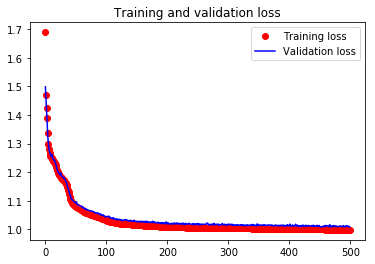

In [17]:
loss = autoencoder_train1.history['loss']
val_loss = autoencoder_train1.history['val_loss']
epochs_plot = range(epochs)
plt.figure()
plt.plot(epochs_plot, loss, 'ro', label='Training loss')
plt.plot(epochs_plot, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [18]:
pred_test1 = vae1.predict(x_test)
pred_train1 = vae1.predict(x_train)

In [ ]:
autoencoder_train2=vae2.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))
vae2.save_weights('vae_explicit_even_circular2.h5')

Train on 40000 samples, validate on 10001 samples
Epoch 1/500
40000/40000 [==============================] - 1s 18us/step - loss: 1.2570 - val_loss: 0.9216
Epoch 2/500
40000/40000 [==============================] - 1s 13us/step - loss: 0.8851 - val_loss: 0.8769
Epoch 3/500
40000/40000 [==============================] - 1s 13us/step - loss: 0.8525 - val_loss: 0.8568
Epoch 4/500
40000/40000 [==============================] - 1s 13us/step - loss: 0.8374 - val_loss: 0.8431
Epoch 5/500
40000/40000 [==============================] - 1s 13us/step - loss: 0.8265 - val_loss: 0.8322
Epoch 6/500
40000/40000 [==============================] - 1s 14us/step - loss: 0.8155 - val_loss: 0.8216
Epoch 7/500
40000/40000 [==============================] - 1s 15us/step - loss: 0.8049 - val_loss: 0.8140
Epoch 8/500
40000/40000 [==============================] - 1s 14us/step - loss: 0.7950 - val_loss: 0.8075
Epoch 9/500
40000/40000 [==============================] - 1s 14us/step - loss: 0.7860 - val_loss: 0.7

40000/40000 [==============================] - 1s 19us/step - loss: 0.5248 - val_loss: 0.5345
Epoch 78/500
40000/40000 [==============================] - 1s 17us/step - loss: 0.5243 - val_loss: 0.5350
Epoch 79/500
40000/40000 [==============================] - 1s 17us/step - loss: 0.5238 - val_loss: 0.5312
Epoch 80/500
40000/40000 [==============================] - 1s 15us/step - loss: 0.5241 - val_loss: 0.5343
Epoch 81/500
40000/40000 [==============================] - 1s 16us/step - loss: 0.5239 - val_loss: 0.5338
Epoch 82/500
40000/40000 [==============================] - 1s 17us/step - loss: 0.5235 - val_loss: 0.5311
Epoch 83/500
40000/40000 [==============================] - 1s 13us/step - loss: 0.5233 - val_loss: 0.5315
Epoch 84/500
40000/40000 [==============================] - 1s 15us/step - loss: 0.5227 - val_loss: 0.5315
Epoch 85/500
40000/40000 [==============================] - 1s 13us/step - loss: 0.5226 - val_loss: 0.5295
Epoch 86/500
40000/40000 [========================

40000/40000 [==============================] - 1s 17us/step - loss: 0.5089 - val_loss: 0.5124
Epoch 154/500
40000/40000 [==============================] - 1s 17us/step - loss: 0.5093 - val_loss: 0.5144
Epoch 155/500
40000/40000 [==============================] - 1s 16us/step - loss: 0.5083 - val_loss: 0.5160
Epoch 156/500
40000/40000 [==============================] - 1s 13us/step - loss: 0.5081 - val_loss: 0.5195
Epoch 157/500
31900/40000 [======================>.......] - ETA: 0s - loss: 0.5080

In [ ]:
loss = autoencoder_train2.history['loss']
val_loss = autoencoder_train2.history['val_loss']
epochs_plot = range(epochs)
plt.figure()
plt.plot(epochs_plot, loss, 'ro', label='Training loss')
plt.plot(epochs_plot, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
autoencoder_train3=vae3.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))
vae3.save_weights('vae_explicit_even_circular3.h5')

In [ ]:
loss = autoencoder_train3.history['loss']
val_loss = autoencoder_train3.history['val_loss']
epochs_plot = range(epochs)
plt.figure()
plt.plot(epochs_plot, loss, 'ro', label='Training loss')
plt.plot(epochs_plot, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
autoencoder_train4=vae4.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))
vae4.save_weights('vae_explicit_even_circular4.h5')

In [ ]:
loss = autoencoder_train4.history['loss']
val_loss = autoencoder_train4.history['val_loss']
epochs_plot = range(epochs)
plt.figure()
plt.plot(epochs_plot, loss, 'ro', label='Training loss')
plt.plot(epochs_plot, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
autoencoder_train5=vae5.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))
vae5.save_weights('vae_explicit_even_circular5.h5')

In [ ]:
loss = autoencoder_train5.history['loss']
val_loss = autoencoder_train5.history['val_loss']
epochs_plot = range(epochs)
plt.figure()
plt.plot(epochs_plot, loss, 'ro', label='Training loss')
plt.plot(epochs_plot, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import explained_variance_score, r2_score

In [ ]:
z_test1 = encoder1.predict(x_test, batch_size=batch_size)
decoder_test1=decoder1.predict(z_test1,batch_size=batch_size)

z_test2 = encoder2.predict(x_test, batch_size=batch_size)
decoder_test2=decoder2.predict(z_test2,batch_size=batch_size)

z_test3 = encoder3.predict(x_test, batch_size=batch_size)
decoder_test3=decoder3.predict(z_test3,batch_size=batch_size)

z_test4 = encoder4.predict(x_test, batch_size=batch_size)
decoder_test4=decoder4.predict(z_test4,batch_size=batch_size)

z_test5 = encoder5.predict(x_test, batch_size=batch_size)
decoder_test5=decoder5.predict(z_test5,batch_size=batch_size)

In [ ]:
fve1 = r2_score(x_test,decoder_test1)
fve2 = r2_score(x_test,decoder_test2)
fve3 = r2_score(x_test,decoder_test3)
fve4 = r2_score(x_test,decoder_test4)
fve5 = r2_score(x_test,decoder_test5)

In [ ]:
fve1

In [ ]:
fve_scores = np.array([fve1,fve2,fve3,fve4,fve5])
x=np.array([1,2,3,4,5])

In [ ]:
fve_scores

In [ ]:
plot(x,fve_scores,'.')